### Constant values

In [ ]:
#constants for this run
labels = ["broadleaf", "grass", "soil", "soybean"]
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42
VAL_SPLIT = 0.30   # train/val split done by flow_from_directory

### Downloading data from Kaggle

Read more at https://www.kaggle.com/datasets/fpeccia/weed-detection-in-soybean-crops

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fpeccia/weed-detection-in-soybean-crops")

print("Path to dataset files:", path)

100%|██████████| 2.37G/2.37G [00:26<00:00, 95.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1


Listing the files, just to have an idea about what's ahappening.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/99.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/789.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/3362.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/3409.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/1823.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/884.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/1838.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/1180.tif
/root/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/grass/3503.tif

### Test set for drone2report case study

We remove 40 samples (ten per class). These files will not be touched in any way during the training.

In [ ]:
#removing the samples named 1..10 from all subfolders. They will become the test
#set in the drone2report case study
import pathlib
for i in range(10):
  #build filename for the four classes
  fname = path + '/dataset/' + labels[0] + '/' + str(i+1) + '.tif'
  pathlib.Path(fname).unlink()
  fname = path + '/dataset/' + labels[1] + '/' + str(i+1) + '.tif'
  pathlib.Path(fname).unlink()
  fname = path + '/dataset/' + labels[2] + '/' + str(i+1) + '.tif'
  pathlib.Path(fname).unlink()
  fname = path + '/dataset/' + labels[3] + '/' + str(i+1) + '.tif'
  pathlib.Path(fname).unlink()

### The deep neural network (ResNet50)

Importing all the necessary stuff

In [ ]:
import os
import glob
import random
import math
import numpy as np
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


We use ImageDataGenerator to sweep the data folders and split train/validation samples. There's about 15k images.

In [ ]:
DATA_DIR = path + '/dataset'

# ImageDataGenerator with model's preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input,
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=labels,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=labels,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

Found 10709 images belonging to 4 classes.
Found 4587 images belonging to 4 classes.


Defining the model: just a resnet plus a little bit of logic after the convolutional part.

In [ ]:
# Build model
base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model check points, early stopping, learning rate management.

In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

### Model training

Standard training and file tuning.

In [ ]:
# Steps
steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
validation_steps = math.ceil(val_gen.samples / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# Train head
EPOCHS_HEAD = 5
history_head = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    verbose=1
)
# Fine-tune: unfreeze last conv layers
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS_FINE = 8
history_fine = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS_FINE,
    callbacks=callbacks,
    verbose=1
)

model.save("resnet50_final.keras")

Steps per epoch: 335 Validation steps: 144


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9008 - loss: 0.3014
Epoch 1: val_accuracy improved from -inf to 0.98627, saving model to /kaggle/working/resnet50_best_generator.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 101s 254ms/step - accuracy: 0.9009 - loss: 0.3009 - val_accuracy: 0.9863 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9762 - loss: 0.0702
Epoch 2: val_accuracy improved from 0.98627 to 0.98670, saving model to /kaggle/working/resnet50_best_generator.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 75s 222ms/step - accuracy: 0.9762 - loss: 0.0702 - val_accuracy: 0.9867 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9828 - loss: 0.0440
Epoch 3: val_accuracy improved from 0.98670 to 0.99281, saving model to /kaggle/working/resnet50_best_generator.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 101s 279ms/step - accuracy: 0.9829 - loss: 0.0440 - val_accuracy: 0.99

In [ ]:
# Combine head + fine-tune histories
train_acc = history_head.history['accuracy'] + history_fine.history['accuracy']
val_acc   = history_head.history['val_accuracy'] + history_fine.history['val_accuracy']

train_loss = history_head.history['loss'] + history_fine.history['loss']
val_loss   = history_head.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(train_acc) + 1)
ft_start = len(history_head.history['accuracy'])   # where fine-tuning starts

print("Total epochs:", len(train_acc))
print("Fine-tuning started at epoch:", ft_start)



Total epochs: 13
Fine-tuning started at epoch: 5


### Performance assessment

Plotting traiing history

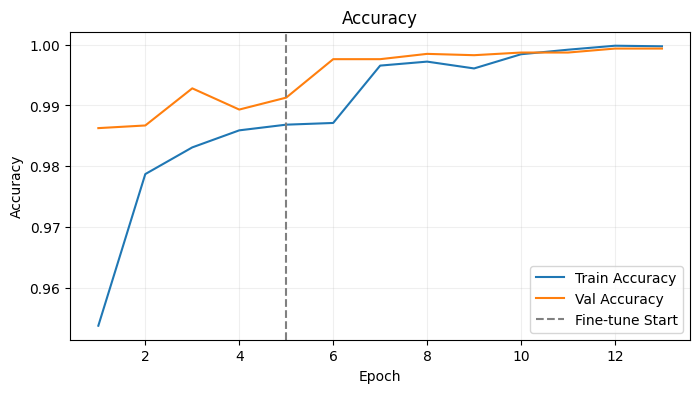

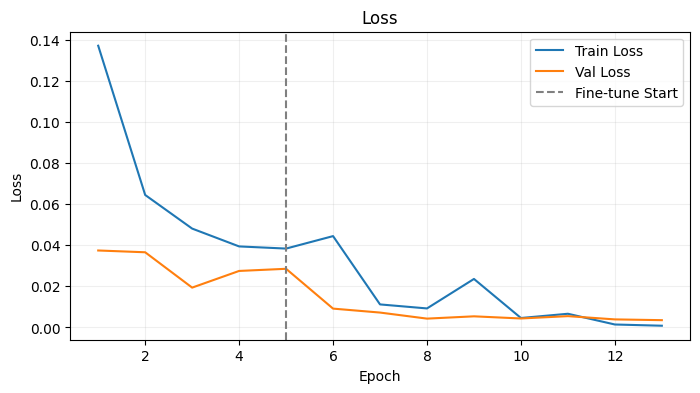

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc,   label='Val Accuracy')
plt.axvline(ft_start, color='gray', linestyle='--', label='Fine-tune Start')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.grid(alpha=0.2); plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss,   label='Val Loss')
plt.axvline(ft_start, color='gray', linestyle='--', label='Fine-tune Start')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(alpha=0.2); plt.legend()
plt.show()

Plotting confusion matrix


Classification Report:
              precision    recall  f1-score   support

   broadleaf     1.0000    0.9944    0.9972       354
       grass     0.9981    1.0000    0.9991      1053
        soil     1.0000    1.0000    1.0000       971
     soybean     0.9995    0.9995    0.9995      2209

    accuracy                         0.9993      4587
   macro avg     0.9994    0.9985    0.9989      4587
weighted avg     0.9993    0.9993    0.9993      4587



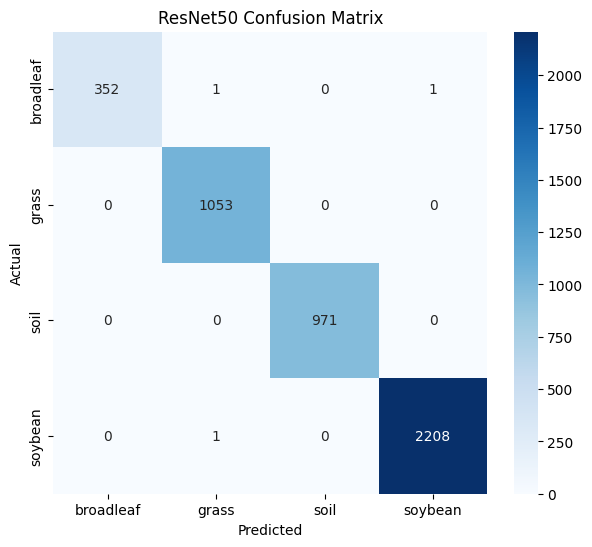

In [ ]:
val_gen.reset()

y_true = []
y_pred = []
for i in range(validation_steps):
    xb, yb = next(val_gen)
    probs = model.predict(xb, verbose=0)
    y_true.extend(np.argmax(yb, axis=1).tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('ResNet50 Confusion Matrix')
plt.show()